![](https://images.pexels.com/photos/1706619/pexels-photo-1706619.jpeg?auto=compress&cs=tinysrgb&dpr=2&h=650&w=940)

# Accelerometer Calibration

Although accelerometers come from the factory calibrated to a rough level for drop detection or car impact detection, this calibration is not sufficient for inerital navigation. Here we are going to follow the AN4508 application note on how to calibrate an accelerometer using least squares.

Following Table 1, we are going to collect measurements in the following 6 orienations:

- x up/down
- y up/down
- z up/down

Then rely on least squares ($Ax=B$) to calculate the misalignments and offsets to recover the *true* measurements. `numpy.linalg.lstsq()` return the least-squares solution to a linear matrix equation.Solves the equation a x = b by computing a vector x that minimizes the Euclidean L2-norm ($|| b – a x ||^2$). 

## References

- AN4508: [Parameters and calibration of a low-g 3-axis accelerometer](AN4508.pdf)
- Vectornav: [Accelerometer](https://www.vectornav.com/support/library/accelerometer)
- [Least squares fitting with Numpy and Scipy](https://mmas.github.io/least-squares-fitting-numpy-scipy)
- GeeksforGeeks: [Numpy Linear Algebra](https://www.geeksforgeeks.org/numpy-linear-algebra/)
- Wikipedia: [Euclidean Distance](https://en.wikipedia.org/wiki/Euclidean_distance)

## Accelerometer Model

We can view the sensor model as a the transformation of the *true* acceleration measurement ($a_i$) morphed into a noisy measurement ($an_i$) due to misalignments, biases (offsets), etc. Mathematically it is:

$$
insert
$$

Now we can solve and get the *ture* acceleration, but then we are going to put it into a form for least squares that looks like $Ax=B$.

$$
\begin{bmatrix}
a_x & a_y & a_z
\end{bmatrix}^T = [A_m]_{3x3} [S]_{3x3} 
\begin{bmatrix}
an_x - b_x & an_y - b_y & an_z - b_z
\end{bmatrix}^T 
$$

where ...

$$
\begin{bmatrix}
a_x & a_y & a_z
\end{bmatrix}^T = [A_mS]_{3x3}
\begin{bmatrix}
an_x & an_y & an_z
\end{bmatrix}^T + [A_mSb]_{3x1} \\
\begin{bmatrix}
a_x & a_y & a_z
\end{bmatrix}^T = [ACC|ACM]_{3x4}
\begin{bmatrix}
an_x & an_y & an_z & 1
\end{bmatrix}^T \\
\begin{bmatrix}
a_x & a_y & a_z
\end{bmatrix} =
\begin{bmatrix}
an_x & an_y & an_z & 1
\end{bmatrix} [(ACC|ACM)^T]_{4x3} = A_{1x4} [x]_{4x3}
$$

Now, for least squares, $A$ becomes our noisy measurements and $B$ is our ideal states. In order to clean up our noisy measurements, we just post-multiply by our $x$ matrix (which least squares finds). So our solution becomes $A_{nx4} [x]_{4x3} = B_{nx3}$ where $n$ is the number of samples we take.

# Calibrate

In [87]:
import numpy as np # matrix manipulations
import os
from scipy import linalg

import the_collector # read data
print(f"the-collector: {the_collector.__version__}")

from the_collector import BagIt
from the_collector import Pickle, Json

from squaternion import Quaternion

import pandas as pd
from glob import glob

%matplotlib inline
from matplotlib import pyplot as plt

# from math import sqrt, atan2, asin, pi
from math import radians as deg2rad
from math import degrees as rad2deg
from math import pi, sin, sqrt

from slurm import storage

from datetime import datetime

the-collector: 0.8.6


In [74]:
!ls ~/github/data-ins-1/2020-5-3-imu/*.bag

/Users/kevin/github/data-ins-1/2020-5-3-imu/still-x-down.pickle.bag
/Users/kevin/github/data-ins-1/2020-5-3-imu/still-x-up.pickle.bag
/Users/kevin/github/data-ins-1/2020-5-3-imu/still-y-down.pickle.bag
/Users/kevin/github/data-ins-1/2020-5-3-imu/still-y-up.pickle.bag
/Users/kevin/github/data-ins-1/2020-5-3-imu/still-z-down.pickle.bag
/Users/kevin/github/data-ins-1/2020-5-3-imu/still-z-up.pickle.bag
/Users/kevin/github/data-ins-1/2020-5-3-imu/tumble.pickle.bag


In [81]:
def gravity(lat):
    return 9.78*(1 + 0.0053*sin(lat)**2 - 0.0000058*sin(2*lat)**2)

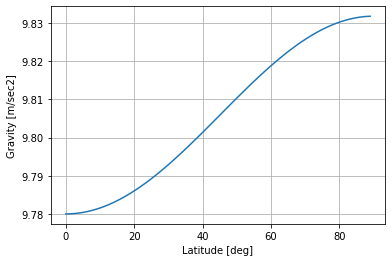

In [85]:
plt.plot(range(90), [gravity(x*pi/180) for x in range(90)])
plt.ylabel("Gravity [m/sec2]")
plt.xlabel("Latitude [deg]")
plt.grid(True);

In [86]:
gps_lat = 38.785809

In [3]:
tmp = "/Users/kevin/github/data-ins-1/2020-5-3-imu/still-*.pickle.bag"
files = glob(tmp)
len(files)

6

In [4]:
def bag_info(bag):
    print('Bag keys:')
    print('-'*50)
    for k in bag.keys():
        print(f'  {k:>10}: {len(bag[k]):<7}')

bag = BagIt(Pickle)

data = bag.read(files[0])
bag_info(data)

>> Reading[pickle]: /Users/kevin/github/data-ins-1/2020-5-3-imu/still-z-up.pickle.bag
Bag keys:
--------------------------------------------------
       accel: 2001   
         mag: 2001   
        gyro: 2001   


In [23]:
def get_np(bag, key, one=False):
    d = []
    for v,ts in bag[key]:
        if one: d.append(v + (1,))
        else: d.append(v)
    return np.array(d)

def get_data(fname, one=False):
    bag = BagIt(Pickle)
    data = bag.read(fname)
    if one: return get_np(data, "accel", True)
    else: return get_np(data, "accel", False)

def get_ideal(orient, num, data=None):
    g = 9.8
    if orient == "x-up":
        nn=np.array([g,0,0]*num).reshape(num,3)
    elif orient == "x-down":
        nn=np.array([-g,0,0]*num).reshape(num,3)
    elif orient == "y-up":
        nn=np.array([0,g,0]*num).reshape(num,3)
    elif orient == "y-down":
        nn=np.array([0,-g,0]*num).reshape(num,3)
    elif orient == "z-up":
        nn=np.array([0,0,g]*num).reshape(num,3)
    elif orient == "z-down":
        nn=np.array([0,0,-g]*num).reshape(num,3)
    else:
        raise Exception("Invalid orientation")
    
    if data is not None:
        nn = np.append(data, nn, 0)
    return nn 

In [39]:
tmp = "/Users/kevin/github/data-ins-1/2020-5-3-imu/still-{}.pickle.bag"

noisy = None
ideal = None

for x in ["x-up", "x-down", "y-up", "y-down", "z-up", "z-down"]:
    d = get_data(tmp.format(x))
    if noisy is None:
        noisy = d
    else:
        noisy = np.append(noisy, d,0)
    ideal = get_ideal(x, d.shape[0], ideal)

print(noisy.shape)
print(ideal.shape)

>> Reading[pickle]: /Users/kevin/github/data-ins-1/2020-5-3-imu/still-x-up.pickle.bag
>> Reading[pickle]: /Users/kevin/github/data-ins-1/2020-5-3-imu/still-x-down.pickle.bag
>> Reading[pickle]: /Users/kevin/github/data-ins-1/2020-5-3-imu/still-y-up.pickle.bag
>> Reading[pickle]: /Users/kevin/github/data-ins-1/2020-5-3-imu/still-y-down.pickle.bag
>> Reading[pickle]: /Users/kevin/github/data-ins-1/2020-5-3-imu/still-z-up.pickle.bag
>> Reading[pickle]: /Users/kevin/github/data-ins-1/2020-5-3-imu/still-z-down.pickle.bag
(12006, 3)
(12006, 3)


In [44]:
noisy[0:3,:]

array([[ 9.79621124, -0.08614159,  0.78723812],
       [ 9.79860306, -0.03828515,  0.73698902],
       [ 9.80817413, -0.03349951,  0.7465601 ]])

In [45]:
ideal[0:3,:]

array([[9.8, 0. , 0. ],
       [9.8, 0. , 0. ],
       [9.8, 0. , 0. ]])

In [70]:
def least_squares_fit(A, B):
    """B = A*x which is: ideal = noisy*x => [n,3] = [n,4][4,3]
    ideal = [n,3] = [x,y,z]
    noisy = [n,4] = [x,y,z,1]: the 1 accounts for the biases
    A = [4,3]: this is a bunch of coefficient matrices
    """
    # Need to extend A and B
    A = np.hstack((A, np.ones(len(A)).reshape(-1, 1)))
    print(A)

    X, res, rank, s = np.linalg.lstsq(A, B, rcond=None)
    print(f"Rank: {rank}")
    print(f"Singular values: {s}")
    print(f"Sum residual error: {np.sum(res)}")
    return X

In [71]:
xx = least_squares_fit(noisy, ideal)
print("--------------------------------")
print(xx)

[[ 9.79621124 -0.08614159  0.78723812  1.        ]
 [ 9.79860306 -0.03828515  0.73698902  1.        ]
 [ 9.80817413 -0.03349951  0.7465601   1.        ]
 ...
 [ 0.16271186 -0.44985044 -9.09032822  1.        ]
 [ 0.14596212 -0.42592227 -9.09750748  1.        ]
 [ 0.16989034 -0.4331007  -9.06161499  1.        ]]
Rank: 4
Singular values: [632.44137865 606.93315748 603.91134494 108.37913904]
Sum residual error: 122.66135735425176
--------------------------------
[[ 1.02397017e+00 -3.45251218e-02 -1.01766435e-03]
 [ 4.23064637e-02  9.98437964e-01  3.35013553e-02]
 [-8.15333320e-03 -2.30016890e-03  1.01480306e+00]
 [-2.25783152e-01  3.89388477e-01 -6.95878339e-01]]


In [48]:
# noisy_measurement * ACC + ACM
print(noisy[1,:])
try:
    print(noisy[1,:].dot(xx[:3,:3]) + xx[3,:])
except:
    print(noisy[1,:].dot(xx))

[ 9.79860306 -0.03828515  0.73698902]
[9.80006551 0.01116997 0.04076608]


In [98]:
def plot(fmt, clean=False, xx=None):
    n = get_data(tmp.format(fmt), clean)
    if clean: n = n.dot(xx)
    c = pd.DataFrame(n, columns=["x","y","z"])
    c["n"] = (c.x**2 + c.y**2 + c.z**2)**0.5
    cx,cy,cz,cn = c.mean()
    csx,csy,csz,csn = 1000*c.std()
    c.plot(
        subplots=True, 
        grid=True, 
        title=f"{fmt}  $\mu$: ({cx:.2f},{cy:.2f},{cz:.2f})m/sec2;  $\sigma$: ({csx:.0f},{csy:.0f},{csz:.0f})mg; g: {cn:.2f}m/sec2");

>> Reading[pickle]: /Users/kevin/github/data-ins-1/2020-5-3-imu/still-x-up.pickle.bag
>> Reading[pickle]: /Users/kevin/github/data-ins-1/2020-5-3-imu/still-x-down.pickle.bag


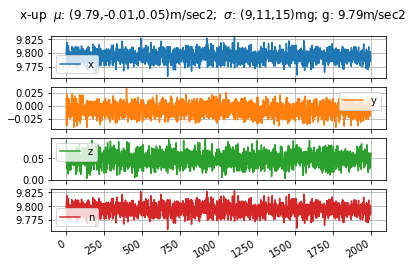

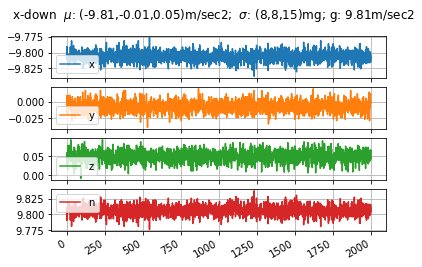

In [99]:
plot("x-up",True,xx)
plot("x-down",True,xx)

>> Reading[pickle]: /Users/kevin/github/data-ins-1/2020-5-3-imu/still-y-up.pickle.bag
>> Reading[pickle]: /Users/kevin/github/data-ins-1/2020-5-3-imu/still-y-down.pickle.bag


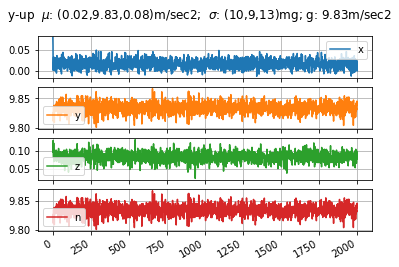

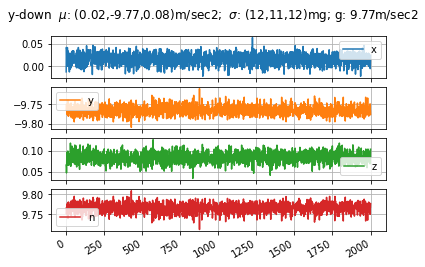

In [100]:
plot("y-up",True,xx)
plot("y-down",True,xx)

>> Reading[pickle]: /Users/kevin/github/data-ins-1/2020-5-3-imu/still-z-up.pickle.bag
>> Reading[pickle]: /Users/kevin/github/data-ins-1/2020-5-3-imu/still-z-down.pickle.bag


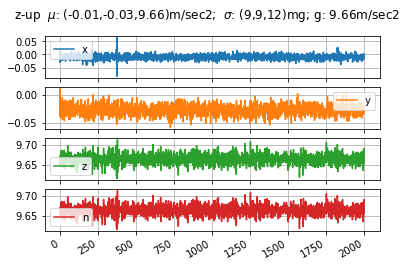

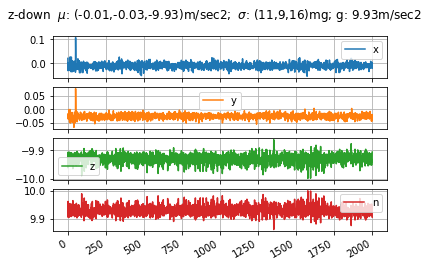

In [101]:
plot("z-up",True,xx)
plot("z-down",True,xx)

# Save Parameters

In [102]:
params = {}
params["imu"] = "adafruit NXP"
params["timestamp"] = datetime.now()
params["accel"] = xx.tolist()
params["shape"] = xx.shape

In [20]:
storage.write("accelerometer.yaml", params)

In [42]:
a = storage.read("accelerometer.yaml")
for k,v in a.items():
    print(f"{k:>10}: {v}")

     accel: [[0.7212673965232941, -0.03309775922872497, 0.368845952504138], [0.02600659456864496, 0.999808594432582, 0.05433589003623909], [-0.13666572053951678, 0.00607150300114645, 1.1970164539777883], [1.3484328086976756, 0.3290084948986502, -2.7154867265855467]]
       imu: adafruit NXP
     shape: [4, 3]
 timestamp: 2020-05-09 14:18:47.581816
